### T238609 QA Init events in EditAttemptSchema
#### While debugging things for Growth Roan found that the 'init' event is not recorded the first time you click edit, only the second time and it seems to me there might be a lot of init events missing.
Fix will be deployed on 11/19 and needs QA to check if inits are firing as expected. See [T238609](https://phabricator.wikimedia.org/T238609)

In [1]:
from time import perf_counter

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from pandas import DataFrame
from tabulate import tabulate
from wmfdata import charting, hive
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


#### Count of Init events
Overall init events were being captured as expected and we couldn't particularly say if there was an issue looking at these numbers. 

In [3]:
Init_events1=hive.run("""
SELECT to_date(dt) as date
, count(*) as events
FROM event.EditAttemptStep
WHERE 
event.action='init'
AND year=2019
AND ((month=10 AND day >10) OR (month=11))
GROUP BY  to_date(dt)
ORDER BY date LIMIT 100
""")


In [4]:
Init_events1['events'] = Init_events1['events'].astype(int).apply(lambda x:"{:,}".format(x)) 
Init_events1

,date,events
0,2019-10-11,"262,316"
1,2019-10-12,"257,564"
2,2019-10-13,"290,710"
3,2019-10-14,"292,429"
4,2019-10-15,"287,895"
5,2019-10-16,"288,616"
6,2019-10-17,"276,913"
7,2019-10-18,"251,284"
8,2019-10-19,"244,988"
9,2019-10-20,"288,998"


##### However, when we look at events for editor interface 'Visual Editor' we see that the init events have drastically dropped from 11-01-19 thru 11-19-19.   

Please ignore the counts from 10-22 to 10-31 as during this week the Editing team was working at deploying a new way to bucket the users in [T236337](https://phabricator.wikimedia.org/T236337) 

In [17]:
Init_events2=hive.run("""
SELECT to_date(dt) as date
, count(*) as events
FROM event.EditAttemptStep
WHERE 
event.action='init'
AND year=2019
AND ((month=10 AND day >10) OR (month=11))
AND event.editor_interface = "visualeditor"
GROUP BY  to_date(dt)
ORDER BY date LIMIT 100
""")


In [18]:
Init_events2['events'] = Init_events2['events'].astype(int).apply(lambda x:"{:,}".format(x)) 
Init_events2

,date,events
0,2019-10-11,"68,324"
1,2019-10-12,"66,398"
2,2019-10-13,"75,572"
3,2019-10-14,"78,922"
4,2019-10-15,"79,668"
5,2019-10-16,"79,034"
6,2019-10-17,"76,998"
7,2019-10-18,"69,400"
8,2019-10-19,"66,272"
9,2019-10-20,"75,315"


### Init event count by Platform 
#### When we investigate further and slice the data by Platform, it seems like this issue has impacted Desktop init events much more than Phone init events   
Please ignore the counts from 10-22 to 10-31 as during this week the Editing team was working at deploying a new way to bucket the users in [T236337](https://phabricator.wikimedia.org/T236337) 

In [19]:
Init_events3=hive.run("""
SELECT to_date(dt) as date
, event.platform as platform
, count(*) as events
FROM event.EditAttemptStep
WHERE 
event.action='init'
AND year=2019
AND ((month=10 AND day >15) 
OR (month=11))
AND event.editor_interface = "visualeditor"
GROUP BY  to_date(dt), event.platform

""")

In [20]:
Init_events3['events'] = Init_events3['events'].astype(int).apply(lambda x:"{:,}".format(x)) 
Init_events3.pivot(index="date", columns="platform")

events        
platform   desktop   phone
date                      
2019-10-16  24,456  54,578
2019-10-17  23,763  53,235
2019-10-18  21,398  48,002
2019-10-19  16,873  49,399
2019-10-20  19,086  56,229
2019-10-21  24,801  51,268
2019-10-22  24,296  18,040
2019-10-23  23,797  17,189
2019-10-24  23,135  16,874
2019-10-25  22,745  16,267
2019-10-26  16,261  17,600
2019-10-27  18,430  17,272
2019-10-28  23,565  16,500
2019-10-29  24,842  17,101
2019-10-30  23,336  17,365
2019-10-31  18,125  17,290
2019-11-01     381  48,758
2019-11-02     381  49,991
2019-11-03     420  57,652
2019-11-04     497  58,386
2019-11-05     494  58,743
2019-11-06     463  58,430
2019-11-07     456  54,765
2019-11-08     450  49,032
2019-11-09     373  50,210
2019-11-10     352  57,773
2019-11-11     451  56,584
2019-11-12     557  56,431
2019-11-13     510  57,855
2019-11-14     521  53,723
2019-11-15     463  48,395
2019-11-16     432  50,891
2019-11-17     368  57,706
2019-11-18     527  57,989
2019-11-19   4,827  57,543
2019-11-20  24,244  56,595
2019-11-21  24,107  55,946
2019-11-22  21,228  48,838
2019-11-23  16,953  49,990
2019-11-24  20,268  59,204
2019-11-25  25,285  57,270
2019-11-26  25,256  56,262
2019-11-27  24,343  55,615
2019-11-28  22,918  55,012
2019-11-29  20,375  46,273
2019-11-30  16,827  47,078

#### Init event count by editor interface for Phone
Checked to see if the events recorded for the editor interfaces on phone - visualeditor and source wikitext has been impacted in any way by this issue and the counts look good!

In [36]:
Init_events4=hive.run("""
SELECT to_date(dt) as date
,  event.editor_interface as  editor_interface
, count(*) as events
FROM event.EditAttemptStep
WHERE 
event.action='init'
AND year=2019
AND ((month=10 AND day >15) OR (month=11))
AND event.platform="phone"
GROUP BY  to_date(dt),  event.editor_interface
ORDER BY date LIMIT 100
""")


In [39]:
Init_events4.pivot(index="date", columns='editor_interface').fillna(0)

events         
editor_interface visualeditor wikitext
date                                  
2019-10-16             54,578   99,258
2019-10-17             53,235   96,435
2019-10-18             48,002   86,786
2019-10-19             49,399   89,393
2019-10-20             56,229  104,178
2019-10-21             51,268  104,483
2019-10-22             18,040  139,742
2019-10-23             17,189  136,455
2019-10-24             16,874  130,009
2019-10-25             16,267  116,137
2019-10-26             17,600  117,079
2019-10-27             17,272  131,944
2019-10-28             16,500  136,419
2019-10-29             17,101  135,858
2019-10-30             17,365  133,186
2019-10-31             17,290  125,161
2019-11-01             48,758   86,758
2019-11-02             49,991   91,774
2019-11-03             57,652  105,517
2019-11-04             58,386  102,064
2019-11-05             58,743  101,343
2019-11-06             58,430  101,988
2019-11-07             54,765   96,585
2019-11-08             49,032   86,486
2019-11-09             50,210   90,898
2019-11-10             57,773  103,152
2019-11-11             56,584   99,536
2019-11-12             56,431  100,378
2019-11-13             57,855  100,597
2019-11-14             53,723   95,800
2019-11-15             48,395   87,140
2019-11-16             50,891   88,700
2019-11-17             57,706  105,144
2019-11-18             57,989  100,919
2019-11-19             57,543  100,129
2019-11-20             56,595   99,044
2019-11-21             55,946   96,386
2019-11-22             48,838   85,834
2019-11-23             49,990   88,156
2019-11-24             59,204  105,415
2019-11-25             57,270   99,055
2019-11-26             56,262   98,149
2019-11-27             55,615   97,721
2019-11-28             55,012   94,093
2019-11-29             46,273   82,809
2019-11-30             47,078   86,097

In [38]:
Init_events4['events'] = Init_events4['events'].astype(int).apply(lambda x:"{:,}".format(x)) 

In [39]:
Init_events7=hive.run("""
SELECT to_date(dt) as date
, event.platform as platform
, event.bucket as bucket
, count(*) as events
FROM event.EditAttemptStep
WHERE 
event.action='init'
AND year=2019
AND month in (10,11)
GROUP BY  to_date(dt), event.platform, event.bucket
""")
Init_Events8=Init_events7.pivot_table(index="date", columns=['platform', 'bucket']).fillna(0)


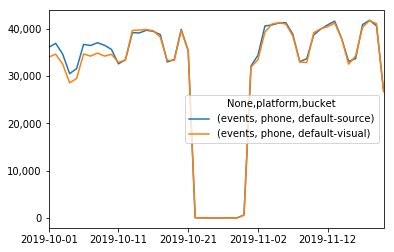

In [40]:
ax2 = Init_Events8.plot()
plt.xlabel(None);
ax2.yaxis.set_major_formatter(comma_fmt)


In [44]:
Init_events9=hive.run("""
SELECT to_date(dt) as date
, event.action as action
, count(*) as events
FROM event.EditAttemptStep
WHERE 
event.action in ('init','ready','loaded')
AND year=2019
AND ((month=10 AND day >15) 
OR (month=11))
GROUP BY  to_date(dt), event.action

""")
Init_events9.pivot_table(index="date", columns="action").applymap(int).fillna(0)

events                
action        init  loaded   ready
date                              
2019-10-16  288616  197829  198053
2019-10-17  276913  192047  192259
2019-10-18  251284  176323  176523
2019-10-19  244988  172214  172364
2019-10-20  288998  197164  197369
2019-10-21  308344  201217  201427
2019-10-22  301299  214814  214994
2019-10-23  287728  210273  210504
2019-10-24  271256  202100  202278
2019-10-25  254407  184312  184509
2019-10-26  241621  177797  177991
2019-10-27  262233  195871  196035
2019-10-28  293528  209787  210020
2019-10-29  296597  211474  211662
2019-10-30  290977  205504  205683
2019-10-31  279978  190633  190791
2019-11-01  244135  154904  155054
2019-11-02  256746  159953  160070
2019-11-03  298465  181522  181672
2019-11-04  301861  180260  180430
2019-11-05  299497  180039  180275
2019-11-06  301024  180218  180408
2019-11-07  295616  172743  172901
2019-11-08  281886  155013  155191
2019-11-09  297122  157896  158035
2019-11-10  308536  177263  177427
2019-11-11  305233  174951  175130
2019-11-12  295152  174862  175031
2019-11-13  294503  176234  176410
2019-11-14  300840  167863  168027
2019-11-15  278436  153365  153553
2019-11-16  290509  155161  155294
2019-11-17  300250  177443  177633
2019-11-18  291284  176129  176321
2019-11-19  291005  180091  180270
2019-11-20  234505  154186  154326

In [45]:
ready_rate_r = hive.run("""
with attempts as (
    select
        date_format(min(dt), "yyyy-MM-dd") as date,
        event.editor_interface as editor,
        sum(cast(event.action = "ready" as int)) >= 1 as ready
    from event.editattemptstep
    where
        event.action in ("init", "ready") and
        event.platform = "phone" and
        year = 2019 and (
        (month = 10 and day > 14) or month=11)
    group by event.editor_interface, event.editing_session_id
)
select
    date,
    editor,
    sum(cast(ready as int)) / count(*) as ready_rate
from attempts
group by date, editor
""")

In [46]:
ready_rate = (
    ready_rate_r
    .assign(date=lambda df: pd.to_datetime(df["date"]).dt.to_period(freq="D"))
    .pivot(index="date", columns="editor")
    .xs("ready_rate", axis=1)
    .reindex(["wikitext", "visualeditor"], axis=1)
)
ready_rate.style.format(pct_str)

editor,wikitext,visualeditor
date,,
2019-10-15,96.5%,65.8%
2019-10-16,96.2%,65.9%
2019-10-17,96.2%,66.3%
2019-10-18,96.7%,67.5%
2019-10-19,96.8%,69.2%
2019-10-20,96.9%,68.9%
2019-10-21,96.6%,65.6%
2019-10-22,96.6%,77.1%
2019-10-23,96.6%,77.2%


In [47]:
Init_events10=hive.run("""
SELECT to_date(dt) as date
, event.action as action
, count(*) as events
FROM event.EditAttemptStep
WHERE 
event.action in ('init','ready','loaded')
AND year=2019
AND ((month=10 AND day >15) 
OR (month=11))
AND event.platform='phone'
GROUP BY  to_date(dt), event.action

""")
Init_events10.pivot_table(index="date", columns="action").applymap(int).fillna(0)

events                
action        init  loaded   ready
date                              
2019-10-16  153836  131434  131465
2019-10-17  149670  128051  128095
2019-10-18  134788  116293  116330
2019-10-19  138792  120733  120744
2019-10-20  160407  139598  139631
2019-10-21  155751  134479  134509
2019-10-22  157782  148839  148852
2019-10-23  153644  144989  145030
2019-10-24  146883  138660  138683
2019-10-25  132404  124790  124814
2019-10-26  134679  126833  126861
2019-10-27  149216  141094  141132
2019-10-28  152919  144646  144685
2019-10-29  152959  144251  144273
2019-10-30  150551  141884  141908
2019-10-31  142451  133945  133976
2019-11-01  135516  116793  116816
2019-11-02  141765  122957  122973
2019-11-03  163169  141727  141744
2019-11-04  160450  136801  136818
2019-11-05  160086  136087  136104
2019-11-06  160418  136733  136760
2019-11-07  151350  128779  128799
2019-11-08  135518  115310  115330
2019-11-09  141108  122019  122031
2019-11-10  160925  138619  138640
2019-11-11  156120  131924  131955
2019-11-12  156809  132046  132075
2019-11-13  158452  133344  133372
2019-11-14  149523  126236  126252
2019-11-15  135535  115539  115555
2019-11-16  139591  120233  120247
2019-11-17  162850  140093  140117
2019-11-18  158908  134089  134108
2019-11-19  157672  132945  132970
2019-11-20  129826  109182  109208